# Kernel Regression

## Loading Packages

In [1]:
using Dates, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")
include("jlFiles/NWFn.jl")
include("jlFiles/OlsFn.jl")

OlsFn

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

## Loading Data

The data consists of daily returns on U.S. large caps. 

We then regress the daily return on the lagged daily return, that is, a non-parametric AR(1)

$
R_t = b(R_{t-1}) + \epsilon_t
$

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
R   = xx[:,11]            #returns for the size portfolio we want to study
xx  = nothing

y   = R[2:end]            #dependent variable
x   = R[1:end-1]          #regressor
T   = size(x,1)

println("Sample size: $T")

Sample size: 8324



A kernel regression is of the form

$
\hat{b}(x)=\frac{\sum_{t=1}^{T}w(x_t-x)y_{t}}{\sum_{t=1}^{T}w(x_t-x)},
$

where $w(x_t-x)$ is the weight of observation $t$, defined by a kernel function.

The function KernRegNormalFn uses a normal kernel, $N(x,h^{2})$.

In [4]:
"""
    KernRegNormalFn(y,x,xGrid,h,vv)

Do kernel regression y[vv] = b(x[vv]), evaluated at xGrid vector, using bandwidth h.

"""
function KernRegNormalFn(y,x,xGrid,h,vv)

  Ngrid = length(xGrid)                  #number of grid points

  bHat = fill(NaN,Ngrid)                 #b[x(t)]
  for i = 1:Ngrid                        #loop over elements in xGrid
    zi      = (x .- xGrid[i])/h
    w       = exp.(-zi.^2/2)./(h*sqrt(2*pi))       #gaussian kernel, with "std" = h
    bHat[i] = sum(w[vv].*y[vv])/sum(w[vv])         #sum over observations, indexed vv
  end

  return bHat

end

KernRegNormalFn

In [5]:
xGrid = collect(-10:0.25:10)
h     = 1.5
bHat    = KernRegNormalFn(y,x,xGrid,h,1:T)         #baseline choice of h
bHatHih = KernRegNormalFn(y,x,xGrid,h*2,1:T)       #high h
bHatLoh = KernRegNormalFn(y,x,xGrid,h*0.5,1:T)     #low h

println("let's plot it")

let's plot it


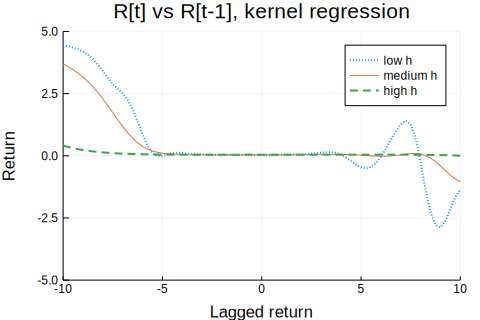

In [6]:
plot(xGrid,bHatLoh,line=(:dot,2),label="low h")
plot!(xGrid,bHat,label="medium h")
plot!(xGrid,bHatHih,line=(:dash,2),label="high h")
plot!(xlim=(minimum(xGrid),maximum(xGrid)),ylim=(-5,5))
title!("R[t] vs R[t-1], kernel regression")
xlabel!("Lagged return")
ylabel!("Return")

## Rule of Thumb Choice of h

Run the regression 

$
y=\alpha+\beta x+\gamma x^{2}+\varepsilon
$

and use the following rule-of-thumb choice

$
h  =T^{-1/5}|\gamma|^{-2/5}\sigma_{\varepsilon}^{2/5}(x_{\max}-x_{\min})^{1/5}\times0.6.
$

In practice, replace $x_{\max}-x_{\min}$ by the difference between the 90th
and 10th percentiles of $x$.

In [7]:
(b,res,) = OlsFn(y,[x.^2 x ones(T)])             #rule of thumb bandwidth

sigma = std(res)
gamm  = b[1]
xSort = sort(x)
x_10  = xSort[floor(Int,T*0.1)]          #crude 10th and 90th percentiles
x_90  = xSort[floor(Int,T*0.9)]

h_crude = 0.6*sigma^(2/5)*abs(gamm)^(-2/5)*(x_90-x_10)^(1/5)*T^(-1/5)

printlnPs("\nRule-of-thumb value of h: ",h_crude)


Rule-of-thumb value of h:      0.667


## Cross-Validation (leave-one-out)

To do a cross-validation 

(1) Pick a bandwidth $h$, do the kernel regression
but leave out observation $t$ and then record the out-of-sample prediction error $y_{t}-\hat{b}_{-t}
(x_{t},h)$. Notice that this is the error for observation $t$ only. 

(2) Repeat for all $t=1-T$ to calculate the EPE

$
\text{EPE}(h)=\sum_{t=1}^{T}[  y_{t}-\hat{b}_{-t}(x_{t},h)]  ^{2}/T,
$

(3) Finally, redo for several different values of $h$---and pick the one
that minimizes EPE$(h)$. 

Notice: Cross-validation calculations *take some time*

In [8]:
hM = h_crude*[0.5;0.75;1;1.5;2;3;4;5;10]

Nh   = length(hM)
EPEM = fill(NaN,(T,Nh))
for t = 1:T
    local v_No_t, b_t
    v_No_t = setdiff(1:T,t)                  #exclude t from estimation
    for j = 1:Nh
        b_t       = KernRegNormalFn(y,x,x[t],hM[j],v_No_t)
        EPEM[t,j] = (y[t] - b_t[1])^2
    end
end

EPE = mean(EPEM,dims=1)'    
println("h and EPE:")
printmat([hM EPE])

h and EPE:
     0.334     1.314
     0.501     1.302
     0.667     1.295
     1.001     1.288
     1.335     1.286
     2.002     1.287
     2.670     1.291
     3.337     1.292
     6.674     1.296



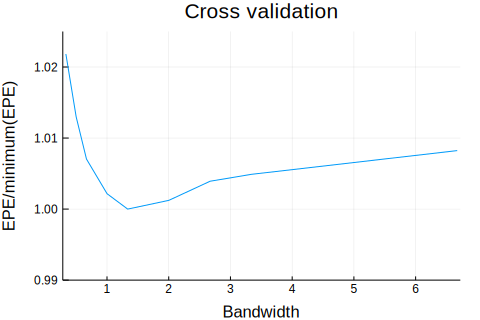

In [9]:
plot(hM,EPE/minimum(EPE),legend=false)
plot!(xlim=(minimum(hM)-0.05,maximum(hM)+0.05),ylim= (0.99,1.025))
title!("Cross validation")
xlabel!("Bandwidth")
ylabel!("EPE/minimum(EPE)")